# Projeto Final - MC886
### Titulo: Como a mobilidade urbana se relaciona com o aumento de numero de casos de covid.

In [1]:
# imports
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense


# %matplotlib notebook

### Carrega dados de Mobilidade do Google

In [2]:
gmr_df = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')
gmr_df.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,ChIJvRKrsd9IXj4RpwoIwFYv0zM,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [3]:
# Categories available
categories_google_mobility = ['retail_and_recreation_percent_change_from_baseline',
 'grocery_and_pharmacy_percent_change_from_baseline',
 'parks_percent_change_from_baseline',
 'transit_stations_percent_change_from_baseline',
 'workplaces_percent_change_from_baseline',
 'residential_percent_change_from_baseline']

regions_list_BR = [ 'Federal District', 'State of Acre','State of Alagoas','State of Amapá', 'State of Amazonas', 
                    'State of Bahia', 'State of Ceará', 'State of Espírito Santo', 'State of Goiás',
                    'State of Maranhão', 'State of Mato Grosso', 'State of Mato Grosso do Sul', 'State of Minas Gerais',
                    'State of Pará', 'State of Paraíba', 'State of Paraná', 'State of Pernambuco', 'State of Piauí', 
                    'State of Rio de Janeiro', 'State of Rio Grande do Norte',
                    'State of Rio Grande do Sul', 'State of Rondônia', 'State of Roraima', 'State of Santa Catarina', 
                    'State of São Paulo', 'State of Sergipe', 'State of Tocantins'
                  ]

regions_abbr_BR = [ 'DF','AC','AL','AP','AM','BA','CE','ES','GO','MA','MT','MS','MG','PA',
                    'PB','PR','PE','PI','RJ','RN','RS','RO','RR','SC','SP','SE','TO']


In [4]:
def getAllRegionsGroups(regions_list=regions_list_BR, country="Brazil"):
    regions_dict = {}
#     print(regions_list)
    for r in regions_list:
        sub_df = gmr_df[(gmr_df['country_region']== country) & (gmr_df['sub_region_1']==r) & (pd.isnull(gmr_df['sub_region_2']))]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[r]=sub_df
#     print(regions_dict)
    return regions_dict

def getCityGroups(cities_list, country="Brazil"):
    regions_dict = {}
#     print(regions_list)
    for r in cities_list:
        sub_df = gmr_df[(gmr_df['country_region']== country) & (gmr_df['sub_region_2']==r)]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[r]=sub_df
#     print(regions_dict)
    return regions_dict


def plotGroups(sub_df, region, country="Brazil"):
    # let's plot all time series for this region
    for group in categories_google_mobility:
        fig, ax = plt.subplots(figsize=(16, 4))
        plt.plot(sub_df['date'], sub_df[group], label=group)
        ax.axhline(y=0, color='gray')
        ax.axvline(pd.to_datetime('2020-03-10'), color='r', linestyle='--', lw=2)
        plt.title(country + ' '+ region + ': ' + group)
        plt.legend(loc='best') 
        plt.grid()
        plt.show()
        

In [5]:
# - - - - - - - -  CASOS DE COVID - - - - - - - -  
covid_df = pd.read_csv('https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv')
col = [ 'epi_week', 'date', 'country', 'state', 'city', 'newDeaths', 'deaths', 'newCases', 'totalCases', 
        'deathsMS', 'totalCasesMS', 'deaths_per_100k_inhabitants', 'totalCases_per_100k_inhabitants', 
        'deaths_by_totalCases', 
        'recovered', 'suspects', 'tests', 'tests_per_100k_inhabitants', 'vaccinated', 
        'vaccinated_per_100_inhabitants', 'vaccinated_second', 
        'vaccinated_second_per_100_inhabitants', 'vaccinated_single', 'vaccinated_single_per_100_inhabitants']

# print(covid_df.head)

def getAllRegionsCovid(regions_list=regions_list_BR, regions_abbr=regions_abbr_BR,
                       country="Brazil"):
    regions_dict = {}
    
    for r in range(len(regions_list)):
        sub_df = covid_df[(covid_df['state']== regions_abbr[r])]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[regions_list[r]]=sub_df
    return regions_dict


    

In [6]:
def getData():
    cases_df = getAllRegionsCovid(regions_list_BR,regions_abbr_BR)
    mob_df = getAllRegionsGroups(regions_list_BR)
    
    mobility_all = []
    cases_all = []
    mobility_dates = []
    cases_dates = []
    mobility_dict = {}
    cases_dict = {}
    mob_date_dict = {}
    cases_date_dict = {}
    
    for r in regions_list_BR:
        newCases = cases_df[r]['newCases'].values
        newCases_norm = newCases/np.max(newCases)
        scaler = MinMaxScaler(feature_range=(-1,1))        
        mobility_norm = scaler.fit_transform(mob_df[r][categories_google_mobility].values)
        
        covid_dates = cases_df[r]['date'].values
        
        mob_dates = mob_df[r]['date'].values
        mob_dates += np.timedelta64(7,'D') # com offset de 7 dias
        
        mobility_dict[r] = mobility_norm
        cases_dict[r] = newCases_norm
        
        mob_date_dict[r] = mob_df[r]['date'].values
        cases_date_dict[r] = cases_df[r]['date'].values
        
        for i in range(len(newCases_norm)):
#             if covid_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            cases_all.append(newCases_norm[i]) 
            cases_dates.append(covid_dates[i])
            
        for i in range(len(mobility_norm)):
#             if mob_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            mobility_all.append(mobility_norm[i])
            mobility_dates.append(mob_dates[i])

    Y_data = (np.array([cases_all]).T)
    X_data = np.array(mobility_all)    
    
    
    return X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict,mob_date_dict,cases_date_dict


X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict,mob_date_dict,cases_date_dict = getData()

print(X_data.shape)
print(Y_data.shape)

(13986, 6)
(13335, 1)


In [7]:
# count_gp = 0

# for group in categories_google_mobility:
#     print(group)
#     group_values = X_data[:,count_gp]
#     fig, ax = plt.subplots(figsize=(8, 4))
#     plt.plot(cases_dates[:], Y_data[:], label="new_cases")
#     plt.plot(mobility_dates[:], group_values[:], label=group)
   
#     plt.legend(loc='best') 
#     plt.grid()
#     plt.show()
    
#     count_gp+=1

In [8]:
def getCorrespondentData(X_data,Y_data, mob_dates=[],c_dates=[]):
    i = 0
    j = 0
    X_f = []
    Y_f = []
    while (i < len(mob_dates)) and (j < len(c_dates)):
#         print(mobility_dates[i]," - ", cases_dates[j])
        if mob_dates[i] == c_dates[j]:
            if not np.any(np.isnan(X_data[i])) and not np.isnan(Y_data[j]):
                X_f.append(X_data[i])
                Y_f.append(Y_data[j])
            i+=1
            j+=1
        elif c_dates[j] > (mob_dates[i] + np.timedelta64(20,'W')):
            j+=1
        elif (mob_dates[i] < c_dates[j]) or mob_dates[i] > (c_dates[j] + np.timedelta64(20,'W')):
            i += 1
        elif (mob_dates[i] > c_dates[j]):
            j += 1
             
    return np.array(X_f), np.array(Y_f)

In [9]:
X_filter, Y_filter = getCorrespondentData(X_data,Y_data, mobility_dates,cases_dates)
print(X_filter.shape)
print(Y_filter.shape)

# i = 0

# for group in categories_google_mobility:
#     print(group)
#     group_values = X_filter[:,i]
#     fig, ax = plt.subplots(figsize=(16, 4))
#     plt.scatter(group_values[:], Y_filter[:], label=group) #com offset de 7 dias
# #     plt.scatter(group_values[-460:], newCases_norm[-463:-3], label=group) #sem offset de 7 dias 
   
#     plt.legend(loc='best') 
#     plt.grid()
#     plt.show()
    
#     i+=1

(13212, 6)
(13212, 1)


In [10]:

X_train = X_filter[:9200]
Y_train = Y_filter[:9200]
X_test = X_filter[9200:]
Y_test = Y_filter[9200:]
# X = mobility_norm[-460:,:]
# Y = newCases_norm[-470:-10]
# Y = Y.reshape((len(Y),1))

print("Mobility Features")
print(X_train[:5])
print("X shape: ",X_train.shape)


print("Covid Cases")
print(Y_train[:5])
print("Y shape: ",Y_train.shape)


print("MobilitY_test Features")
print(X_test[:5])
print("X_test shape: ",X_test.shape)
print("Teste ",regions_list_BR[21])

print("Covid Cases")
print(Y_test[:5])
print("Y_test shape: ",Y_test.shape)

Mobility Features
[[ 0.6344086   0.0483871  -0.35403727  0.45679012  0.56190476 -0.5       ]
 [ 0.6344086   0.16129032 -0.36645963  0.48148148  0.46666667 -0.4375    ]
 [ 0.5483871  -0.0483871  -0.22981366  0.80246914  0.86666667 -0.8125    ]
 [ 0.69892473  0.11290323 -0.04347826  0.85185185  0.86666667 -0.875     ]
 [ 0.65591398  0.08064516 -0.0310559   0.82716049  0.86666667 -0.875     ]]
X shape:  (9200, 6)
Covid Cases
[[0.00031536]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.00031536]]
Y shape:  (9200, 1)
MobilitY_test Features
[[ 0.17021277  0.33834586 -0.42857143  0.02857143  0.37634409 -0.35483871]
 [ 0.29787234  0.45864662 -0.45918367  0.12380952  0.44086022 -0.35483871]
 [ 0.21276596  0.41353383 -0.55102041  0.08571429  0.5483871  -0.48387097]
 [-0.10638298  0.21804511 -0.73469388 -0.14285714  0.44086022 -0.29032258]
 [ 0.23404255  0.36842105 -0.58163265  0.02857143  0.39784946 -0.35483871]]
X_test shape:  (4012, 6)
Teste  State of Rondônia
Covid Cases
[[0.2279804 ]
 [0.2727

In [11]:
model = Sequential()
model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(1, activation='relu'))

In [12]:


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, validation_split=0.15, epochs=700, batch_size=180, shuffle=True)



Epoch 1/700
44/44 [==============================] - 22s 18ms/step - loss: 0.6439 - accuracy: 0.0135 - val_loss: 0.5454 - val_accuracy: 0.0138
Epoch 2/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5397 - accuracy: 0.0130 - val_loss: 0.5383 - val_accuracy: 0.0138
Epoch 3/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5275 - accuracy: 0.0154 - val_loss: 0.5350 - val_accuracy: 0.0138
Epoch 4/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5174 - accuracy: 0.0156 - val_loss: 0.5320 - val_accuracy: 0.0138
Epoch 5/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5180 - accuracy: 0.0136 - val_loss: 0.5299 - val_accuracy: 0.0138
Epoch 6/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5178 - accuracy: 0.0185 - val_loss: 0.5278 - val_accuracy: 0.0138
Epoch 7/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5165 - accuracy: 0.0159 - val_loss: 0.5262 - val_accuracy: 0.0138
Epoch 8/700

44/44 [==============================] - 0s 2ms/step - loss: 0.5018 - accuracy: 0.0140 - val_loss: 0.5208 - val_accuracy: 0.0138
Epoch 59/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4994 - accuracy: 0.0146 - val_loss: 0.5212 - val_accuracy: 0.0138
Epoch 60/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5021 - accuracy: 0.0138 - val_loss: 0.5225 - val_accuracy: 0.0138
Epoch 61/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5028 - accuracy: 0.0140 - val_loss: 0.5208 - val_accuracy: 0.0138
Epoch 62/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5009 - accuracy: 0.0135 - val_loss: 0.5209 - val_accuracy: 0.0138
Epoch 63/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4984 - accuracy: 0.0159 - val_loss: 0.5219 - val_accuracy: 0.0138
Epoch 64/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5041 - accuracy: 0.0183 - val_loss: 0.5180 - val_accuracy: 0.0138
Epoch 65/700
44/44 

Epoch 116/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4972 - accuracy: 0.0164 - val_loss: 0.5202 - val_accuracy: 0.0138
Epoch 117/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4938 - accuracy: 0.0132 - val_loss: 0.5225 - val_accuracy: 0.0138
Epoch 118/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4970 - accuracy: 0.0168 - val_loss: 0.5186 - val_accuracy: 0.0138
Epoch 119/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4972 - accuracy: 0.0129 - val_loss: 0.5202 - val_accuracy: 0.0138
Epoch 120/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4986 - accuracy: 0.0150 - val_loss: 0.5196 - val_accuracy: 0.0138
Epoch 121/700
44/44 [==============================] - 0s 2ms/step - loss: 0.5023 - accuracy: 0.0163 - val_loss: 0.5180 - val_accuracy: 0.0138
Epoch 122/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4942 - accuracy: 0.0168 - val_loss: 0.5212 - val_accuracy: 0.0138

44/44 [==============================] - 0s 2ms/step - loss: 0.5014 - accuracy: 0.0129 - val_loss: 0.5193 - val_accuracy: 0.0138
Epoch 174/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4958 - accuracy: 0.0152 - val_loss: 0.5204 - val_accuracy: 0.0138
Epoch 175/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4967 - accuracy: 0.0144 - val_loss: 0.5185 - val_accuracy: 0.0138
Epoch 176/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4944 - accuracy: 0.0156 - val_loss: 0.5190 - val_accuracy: 0.0138
Epoch 177/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4971 - accuracy: 0.0142 - val_loss: 0.5204 - val_accuracy: 0.0138
Epoch 178/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4985 - accuracy: 0.0178 - val_loss: 0.5196 - val_accuracy: 0.0138
Epoch 179/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4944 - accuracy: 0.0165 - val_loss: 0.5212 - val_accuracy: 0.0138
Epoch 180/700

44/44 [==============================] - 0s 2ms/step - loss: 0.4931 - accuracy: 0.0160 - val_loss: 0.5225 - val_accuracy: 0.0138
Epoch 231/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4909 - accuracy: 0.0163 - val_loss: 0.5198 - val_accuracy: 0.0138
Epoch 232/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4944 - accuracy: 0.0146 - val_loss: 0.5188 - val_accuracy: 0.0138
Epoch 233/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4914 - accuracy: 0.0149 - val_loss: 0.5183 - val_accuracy: 0.0138
Epoch 234/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4946 - accuracy: 0.0155 - val_loss: 0.5185 - val_accuracy: 0.0138
Epoch 235/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4903 - accuracy: 0.0142 - val_loss: 0.5195 - val_accuracy: 0.0138
Epoch 236/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4971 - accuracy: 0.0137 - val_loss: 0.5183 - val_accuracy: 0.0138
Epoch 237/700

44/44 [==============================] - 0s 2ms/step - loss: 0.4975 - accuracy: 0.0155 - val_loss: 0.5195 - val_accuracy: 0.0138
Epoch 288/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4943 - accuracy: 0.0145 - val_loss: 0.5190 - val_accuracy: 0.0138
Epoch 289/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4935 - accuracy: 0.0164 - val_loss: 0.5215 - val_accuracy: 0.0138
Epoch 290/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4994 - accuracy: 0.0154 - val_loss: 0.5180 - val_accuracy: 0.0138
Epoch 291/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4921 - accuracy: 0.0153 - val_loss: 0.5197 - val_accuracy: 0.0138
Epoch 292/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4951 - accuracy: 0.0168 - val_loss: 0.5167 - val_accuracy: 0.0138
Epoch 293/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4957 - accuracy: 0.0161 - val_loss: 0.5185 - val_accuracy: 0.0138
Epoch 294/700

44/44 [==============================] - 0s 2ms/step - loss: 0.4883 - accuracy: 0.0147 - val_loss: 0.5187 - val_accuracy: 0.0138
Epoch 345/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4903 - accuracy: 0.0177 - val_loss: 0.5187 - val_accuracy: 0.0138
Epoch 346/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4952 - accuracy: 0.0129 - val_loss: 0.5161 - val_accuracy: 0.0138
Epoch 347/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4948 - accuracy: 0.0146 - val_loss: 0.5153 - val_accuracy: 0.0138
Epoch 348/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4956 - accuracy: 0.0147 - val_loss: 0.5184 - val_accuracy: 0.0138
Epoch 349/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4898 - accuracy: 0.0135 - val_loss: 0.5156 - val_accuracy: 0.0138
Epoch 350/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4947 - accuracy: 0.0139 - val_loss: 0.5152 - val_accuracy: 0.0138
Epoch 351/700

44/44 [==============================] - 0s 2ms/step - loss: 0.4954 - accuracy: 0.0151 - val_loss: 0.5157 - val_accuracy: 0.0138
Epoch 402/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4907 - accuracy: 0.0159 - val_loss: 0.5174 - val_accuracy: 0.0138
Epoch 403/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4852 - accuracy: 0.0132 - val_loss: 0.5138 - val_accuracy: 0.0138
Epoch 404/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4966 - accuracy: 0.0136 - val_loss: 0.5163 - val_accuracy: 0.0138
Epoch 405/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4948 - accuracy: 0.0173 - val_loss: 0.5197 - val_accuracy: 0.0138
Epoch 406/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 0.0141 - val_loss: 0.5179 - val_accuracy: 0.0138
Epoch 407/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4897 - accuracy: 0.0169 - val_loss: 0.5137 - val_accuracy: 0.0138
Epoch 408/700

44/44 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.0141 - val_loss: 0.5172 - val_accuracy: 0.0138
Epoch 459/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4911 - accuracy: 0.0136 - val_loss: 0.5165 - val_accuracy: 0.0138
Epoch 460/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4896 - accuracy: 0.0163 - val_loss: 0.5165 - val_accuracy: 0.0138
Epoch 461/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4875 - accuracy: 0.0153 - val_loss: 0.5155 - val_accuracy: 0.0138
Epoch 462/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4897 - accuracy: 0.0152 - val_loss: 0.5169 - val_accuracy: 0.0138
Epoch 463/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4900 - accuracy: 0.0173 - val_loss: 0.5190 - val_accuracy: 0.0138
Epoch 464/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4911 - accuracy: 0.0153 - val_loss: 0.5171 - val_accuracy: 0.0138
Epoch 465/700

44/44 [==============================] - 0s 2ms/step - loss: 0.4866 - accuracy: 0.0146 - val_loss: 0.5202 - val_accuracy: 0.0138
Epoch 516/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.0152 - val_loss: 0.5176 - val_accuracy: 0.0138
Epoch 517/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4915 - accuracy: 0.0154 - val_loss: 0.5213 - val_accuracy: 0.0138
Epoch 518/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4857 - accuracy: 0.0161 - val_loss: 0.5211 - val_accuracy: 0.0138
Epoch 519/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4896 - accuracy: 0.0166 - val_loss: 0.5212 - val_accuracy: 0.0138
Epoch 520/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4847 - accuracy: 0.0182 - val_loss: 0.5168 - val_accuracy: 0.0138
Epoch 521/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4917 - accuracy: 0.0156 - val_loss: 0.5183 - val_accuracy: 0.0138
Epoch 522/700

44/44 [==============================] - 0s 2ms/step - loss: 0.4875 - accuracy: 0.0161 - val_loss: 0.5234 - val_accuracy: 0.0138
Epoch 573/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4872 - accuracy: 0.0162 - val_loss: 0.5206 - val_accuracy: 0.0138
Epoch 574/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4880 - accuracy: 0.0175 - val_loss: 0.5215 - val_accuracy: 0.0138
Epoch 575/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4867 - accuracy: 0.0177 - val_loss: 0.5196 - val_accuracy: 0.0138
Epoch 576/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4877 - accuracy: 0.0167 - val_loss: 0.5165 - val_accuracy: 0.0138
Epoch 577/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4910 - accuracy: 0.0155 - val_loss: 0.5140 - val_accuracy: 0.0138
Epoch 578/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 0.0162 - val_loss: 0.5181 - val_accuracy: 0.0138
Epoch 579/700

44/44 [==============================] - 0s 2ms/step - loss: 0.4894 - accuracy: 0.0151 - val_loss: 0.5210 - val_accuracy: 0.0138
Epoch 630/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4898 - accuracy: 0.0152 - val_loss: 0.5225 - val_accuracy: 0.0138
Epoch 631/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4837 - accuracy: 0.0147 - val_loss: 0.5196 - val_accuracy: 0.0138
Epoch 632/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4891 - accuracy: 0.0162 - val_loss: 0.5189 - val_accuracy: 0.0138
Epoch 633/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4863 - accuracy: 0.0168 - val_loss: 0.5197 - val_accuracy: 0.0138
Epoch 634/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4899 - accuracy: 0.0134 - val_loss: 0.5214 - val_accuracy: 0.0138
Epoch 635/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4847 - accuracy: 0.0168 - val_loss: 0.5258 - val_accuracy: 0.0145
Epoch 636/700

44/44 [==============================] - 0s 2ms/step - loss: 0.4884 - accuracy: 0.0159 - val_loss: 0.5199 - val_accuracy: 0.0138
Epoch 687/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4929 - accuracy: 0.0152 - val_loss: 0.5242 - val_accuracy: 0.0130
Epoch 688/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4868 - accuracy: 0.0143 - val_loss: 0.5240 - val_accuracy: 0.0138
Epoch 689/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4965 - accuracy: 0.0164 - val_loss: 0.5214 - val_accuracy: 0.0138
Epoch 690/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4878 - accuracy: 0.0148 - val_loss: 0.5207 - val_accuracy: 0.0138
Epoch 691/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4890 - accuracy: 0.0157 - val_loss: 0.5172 - val_accuracy: 0.0138
Epoch 692/700
44/44 [==============================] - 0s 2ms/step - loss: 0.4871 - accuracy: 0.0156 - val_loss: 0.5209 - val_accuracy: 0.0138
Epoch 693/700

In [13]:
print(categories_google_mobility)
print(len(model.get_weights()))
print(model.get_weights()[0])
print(model.get_weights()[1])
print(model.get_weights()[2])
print(model.get_weights()[3])
print(model.get_weights()[4])
print(model.get_weights()[5])
print(model.get_weights()[6])
print(model.get_weights()[7])
print(model.get_weights()[8])
print(model.get_weights()[9])

['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
10
[[-0.06196984  0.2938939   0.3207686   0.75514966  0.6643673  -0.18063356]
 [-0.03401376  0.18797326  0.48866254 -0.26262727 -0.88753957 -0.15429454]
 [-0.05627413  0.6029518  -0.46058765  0.15900311 -0.31043804  0.6950012 ]
 [ 0.5246169  -0.34716725  0.20035452  0.516375   -0.2862695  -0.1390242 ]
 [ 0.329093    0.83156693  0.3349141  -0.5948232   0.5796768   0.54868126]
 [-0.6324176   0.15752642  0.36022505  0.24332158  0.14270258  0.5983435 ]]
[-0.37308165  0.15727289  0.3424925   0.40275967 -0.05406685  0.24560584]
[[ 0.4775695   0.38720956  0.31765404  0.2896649  -0.17977023 -0.05129185
  -0.30971536  0.10072238  0.06595006 -0.27640206  0.35273734 -0.6262194 ]
 [-0.29686052 -0.29138064  0.12959701  0.

In [14]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, Y_train)
print('Accuracy: %.2f' % (accuracy*100))

288/288 [==============================] - 0s 800us/step - loss: 0.4924 - accuracy: 0.0154
Accuracy: 1.54


In [15]:
# newCases = cases_df[regions_selected[2]]['newCases'].values
# newCases_norm = newCases/np.max(newCases)
# mobility_norm = scaler.fit_transform(mob_df[regions_selected[2]][categories_google_mobility].values)

In [16]:
# X_test = mobility_norm[-460:,:]
# Y_test = newCases_norm[-470:-10]
# Y_test = Y_test.reshape((len(Y_test),1))
# X_test = mobility_dict[regions_list_BR[21]][-460:,:]
# Y_test = cases_dict[regions_list_BR[21]][-460:]
# Y_test = Y_test.reshape((len(Y_test),1))

print("MobilitY_test Features")
print(X_test[:5])
print("X_test shape: ",X_test.shape)
print("Teste ",regions_list_BR[21])

print("Covid Cases")
print(Y_test[:5])
print("Y_test shape: ",Y_test.shape)

_, accuracY_test = model.evaluate(X_test, Y_test)
print('AccuracY_test: %.2f' % (accuracY_test*100))

MobilitY_test Features
[[ 0.17021277  0.33834586 -0.42857143  0.02857143  0.37634409 -0.35483871]
 [ 0.29787234  0.45864662 -0.45918367  0.12380952  0.44086022 -0.35483871]
 [ 0.21276596  0.41353383 -0.55102041  0.08571429  0.5483871  -0.48387097]
 [-0.10638298  0.21804511 -0.73469388 -0.14285714  0.44086022 -0.29032258]
 [ 0.23404255  0.36842105 -0.58163265  0.02857143  0.39784946 -0.35483871]]
X_test shape:  (4012, 6)
Teste  State of Rondônia
Covid Cases
[[0.2279804 ]
 [0.27272727]
 [0.24833968]
 [0.02917801]
 [0.11823625]]
Y_test shape:  (4012, 1)
126/126 [==============================] - 0s 798us/step - loss: 0.4785 - accuracy: 0.0366
AccuracY_test: 3.66


In [17]:
def printSaveGraph(X_t,Y_t,pred,imgName,keras_model):
    fig = plt.figure(figsize=(18, 4))
    plt.plot(Y_t,label="Ground Truth")
    plt.plot(pred,label="Predict")
    plt.legend(loc='best')
    plt.savefig(imgName+'.png')
    plt.show()
    
    _, accuracy = keras_model.evaluate(X_t, Y_t)
    print('Accuracy: %.2f' % (accuracy*100))

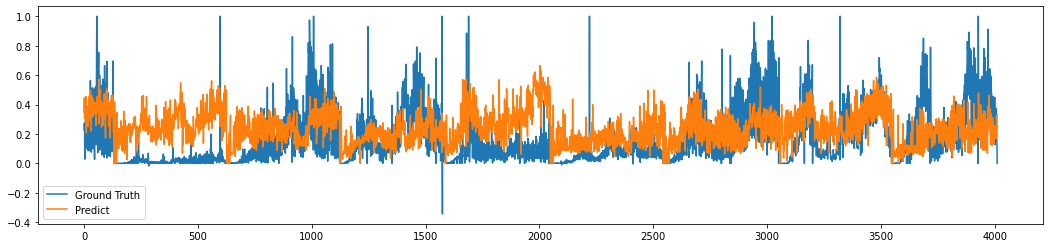

126/126 [==============================] - 0s 2ms/step - loss: 0.4785 - accuracy: 0.0366
Accuracy: 3.66


In [18]:
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'BR_test',model)


Teste  State of Rondônia


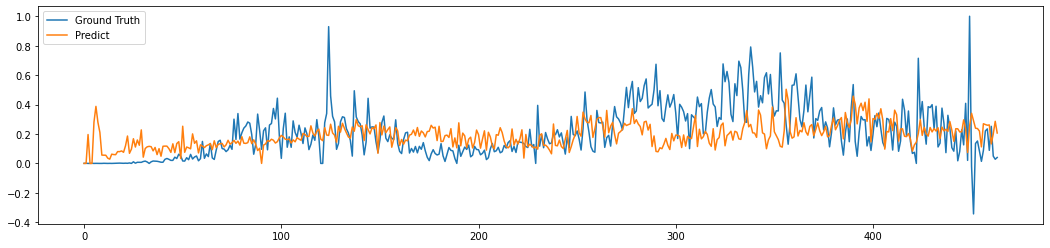

15/15 [==============================] - 0s 1ms/step - loss: 0.5139 - accuracy: 0.0323
Accuracy: 3.23


In [19]:

rgName=regions_list_BR[21]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'RO_test',model)

Teste  State of Roraima


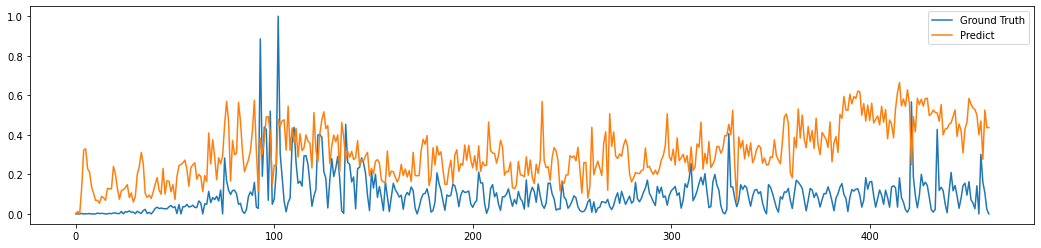

15/15 [==============================] - 0s 1ms/step - loss: 0.4609 - accuracy: 0.0369
Accuracy: 3.69


In [20]:
rgName=regions_list_BR[22]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'RR_test',model)

Teste  State of Santa Catarina


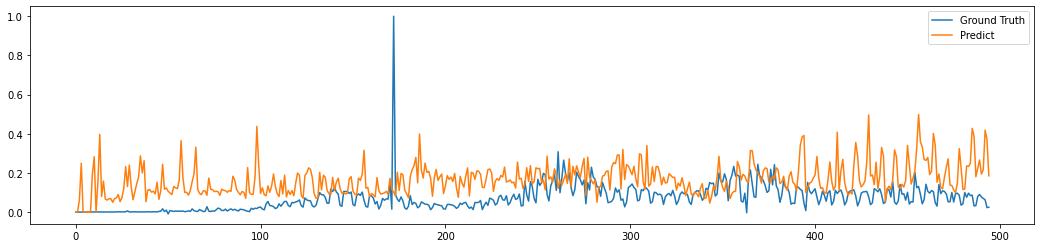

16/16 [==============================] - 0s 2ms/step - loss: 0.3012 - accuracy: 0.0020
Accuracy: 0.20


In [21]:
rgName=regions_list_BR[23]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'SC_test',model)

Teste  State of São Paulo


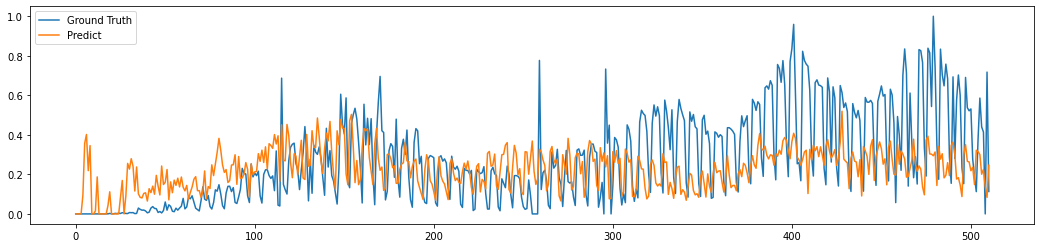

16/16 [==============================] - 0s 1ms/step - loss: 0.5798 - accuracy: 0.0274
Accuracy: 2.74


In [22]:
rgName=regions_list_BR[24]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'SP_test',model)

Teste  State of Sergipe


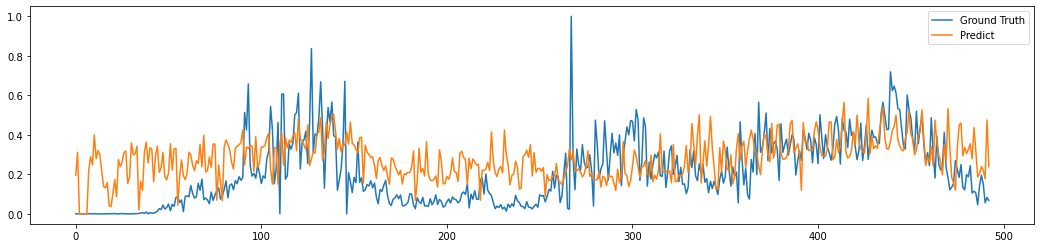

16/16 [==============================] - 0s 1ms/step - loss: 0.5161 - accuracy: 0.0284
Accuracy: 2.84


In [23]:
rgName=regions_list_BR[25]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'SE_test',model)

Teste  State of Tocantins


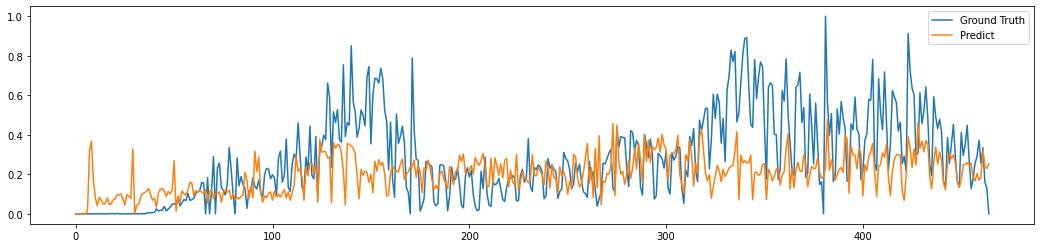

15/15 [==============================] - 0s 1ms/step - loss: 0.5801 - accuracy: 0.0409
Accuracy: 4.09


In [24]:
rgName=regions_list_BR[26]
X_test, Y_test = getCorrespondentData(mobility_dict[rgName],cases_dict[rgName], 
                                        mob_date_dict[rgName],cases_date_dict[rgName])
print("Teste ",rgName)
predict = model.predict(X_test)
printSaveGraph(X_test,Y_test,predict, 'TO_test',model)

In [25]:
# cities_selected=['São Paulo/SP','Campinas/SP','Guarulhos/SP','São Bernardo do Campo/SP',
#                  'Santo André/SP','Ribeirão Preto/SP','Osasco/SP','Sorocaba/SP','Mauá/SP','São José do Rio Preto/SP',
#                  'Mogi das Cruzes/SP','Santos/SP','Diadema/SP','Jundiaí/SP', 'Piracicaba/SP','Carapicuíba/SP',
#                  'Bauru/SP','Itaquaquecetuba/SP','São Vicente/SP','Franca/SP','Marília/SP']

In [27]:


def getSelectedCities(df,cities_list):
    regions_dict = {}
    
#     print(regions_list)
    for r in cities_list:
        sub_df = df[(df['city']== r)]
        sub_df.loc[:,'date'] = pd.to_datetime(sub_df.loc[:,'date'])
        sub_df = sub_df.sort_values('date', ascending=True)
        regions_dict[r[:-3]]=sub_df
#     print(regions_dict)
    return regions_dict


cities_cols = ['epi_week','date','country','state',
               'city','ibgeID','newDeaths','deaths','newCases',
               'totalCases','deaths_per_100k_inhabitants',
               'totalCases_per_100k_inhabitants','deaths_by_totalCases','_source','last_info_date'
               ]

cities_selected=['São Bernardo do Campo/SP','Santo André/SP',
                 'Osasco/SP','Sorocaba/SP','Mauá/SP','São José do Rio Preto/SP',
                 'Mogi das Cruzes/SP','Diadema/SP','Jundiaí/SP', 'Piracicaba/SP',
                 'Belo Horizonte/MG','Vitória/ES',
                 'Santos/SP', 'Florianópolis/SC','Salvador/BA','Fortaleza/CE','Recife/PE',
                 'Goiânia/GO','Belém/PA','Guarulhos/SP','São Luís/MA','São Gonçalo/RJ','Maceió/AL',
                 'Duque de Caxias/RJ','Campo Grande/MS','São Paulo/SP',
                 'Porto Alegre/RS','Curitiba/PR','Manaus/AM',
                 'Rio de Janeiro/RJ','Natal/RN','Ribeirão Preto/SP','Campinas/SP']
mob_cities_selected=[i[:-3] for i in cities_selected]
# print(mob_cities_selected)

cities_df = pd.read_csv('cases-brazil-cities-time_changesOnly.csv')
cities_covid = getSelectedCities(cities_df,cities_selected)
mob_cities = getCityGroups(mob_cities_selected)
# print(mob_cities)

In [28]:
def getCitiesData(mob_df,cases_df,cities_list):
    mobility_all = []
    cases_all = []
    mobility_dates = []
    cases_dates = []
    mobility_dict = {}
    cases_dict = {}
    mob_date_dict = {}
    cases_date_dict = {}
    
    for r in cities_list:
        newCases = cases_df[r]['newCases'].values
        newCases_norm = newCases/np.max(newCases)
        scaler = MinMaxScaler(feature_range=(-1,1))        
        mobility_norm = scaler.fit_transform(mob_df[r][categories_google_mobility].values)
        
        covid_dates = cases_df[r]['date'].values
        
        mob_dates = mob_df[r]['date'].values
        mob_dates += np.timedelta64(7,'D') # com offset de 7 dias
        
        mobility_dict[r] = mobility_norm
        cases_dict[r] = newCases_norm
        
        mob_date_dict[r] = mob_df[r]['date'].values
        cases_date_dict[r] = cases_df[r]['date'].values
        
        for i in range(len(newCases_norm)):
#             if covid_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            cases_all.append(newCases_norm[i]) 
            cases_dates.append(covid_dates[i])
            
        for i in range(len(mobility_norm)):
#             if mob_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
            mobility_all.append(mobility_norm[i])
            mobility_dates.append(mob_dates[i])

    Y_data = (np.array([cases_all]).T)
    X_data = np.array(mobility_all)    
    
    
    return X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict, mob_date_dict, cases_date_dict


Xc_data, Yc_data, mobility_ct_dates, cases_ct_dates, mobility_ct_dict, cases_ct_dict,mob_date_ct_dict, cases_date_ct_dict = getCitiesData(mob_cities,cities_covid,mob_cities_selected)

print(Xc_data.shape)
print(Yc_data.shape)

(17094, 6)
(15219, 1)


In [29]:
Xc_filter, Yc_filter = getCorrespondentData(Xc_data,Yc_data, mobility_ct_dates,cases_ct_dates)
print(Xc_filter.shape)
print(Yc_filter.shape)

Xc_train = Xc_filter[:11000]
Yc_train = Yc_filter[:11000]
Xc_test = Xc_filter[11000:]
Yc_test = Yc_filter[11000:]
# X = mobility_norm[-460:,:]
# Y = newCases_norm[-470:-10]
# Y = Y.reshape((len(Y),1))

print("Mobility Features")
print(Xc_train[:5])
print("X shape: ",Xc_train.shape)


print("Covid Cases")
print(Yc_train[:5])
print("Y shape: ",Yc_train.shape)

(14957, 6)
(14957, 1)
Mobility Features
[[ 6.87500000e-01  2.62411348e-01  1.44927536e-01  2.94964029e-01
   8.83495146e-01 -8.88888889e-01]
 [ 7.91666667e-01  2.19858156e-01  7.24637681e-02  3.38129496e-01
   8.64077670e-01 -9.44444444e-01]
 [ 7.91666667e-01  3.61702128e-01  4.20289855e-01  2.23021583e-01
   9.22330097e-01 -9.44444444e-01]
 [ 2.70833333e-01  3.75886525e-01 -1.59420290e-01 -1.36690647e-01
   3.98058252e-01 -3.33333333e-01]
 [-1.04166667e-01  2.19858156e-01 -2.17391304e-01 -4.67625899e-01
   1.26213592e-01 -1.11022302e-16]]
X shape:  (11000, 6)
Covid Cases
[[0.00093023]
 [0.00186047]
 [0.00093023]
 [0.00837209]
 [0.00186047]]
Y shape:  (11000, 1)


In [30]:

city_model = Sequential()
city_model.add(Dense(6, input_dim=6, activation='relu'))
city_model.add(Dense(12, activation='relu'))
# city_model.add(Dense(12, activation='relu'))
city_model.add(Dense(6, activation='relu'))
city_model.add(Dense(1, activation='relu'))
city_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

city_model.fit(Xc_train, Yc_train, validation_split=0.15,epochs=600, batch_size=180)



Epoch 1/600
52/52 [==============================] - 3s 17ms/step - loss: 2.3021 - accuracy: 0.0091 - val_loss: 0.7023 - val_accuracy: 0.0030
Epoch 2/600
52/52 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.0088 - val_loss: 0.3950 - val_accuracy: 0.0030
Epoch 3/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4663 - accuracy: 0.0081 - val_loss: 0.3868 - val_accuracy: 0.0030
Epoch 4/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4613 - accuracy: 0.0099 - val_loss: 0.3858 - val_accuracy: 0.0030
Epoch 5/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4583 - accuracy: 0.0100 - val_loss: 0.3855 - val_accuracy: 0.0030
Epoch 6/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4629 - accuracy: 0.0096 - val_loss: 0.3850 - val_accuracy: 0.0030
Epoch 7/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4590 - accuracy: 0.0082 - val_loss: 0.3842 - val_accuracy: 0.0030
Epoch 8/600


Epoch 59/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.0092 - val_loss: 0.3761 - val_accuracy: 0.0030
Epoch 60/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4513 - accuracy: 0.0091 - val_loss: 0.3778 - val_accuracy: 0.0030
Epoch 61/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4499 - accuracy: 0.0085 - val_loss: 0.3820 - val_accuracy: 0.0030
Epoch 62/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4510 - accuracy: 0.0075 - val_loss: 0.3777 - val_accuracy: 0.0030
Epoch 63/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4528 - accuracy: 0.0089 - val_loss: 0.3787 - val_accuracy: 0.0030
Epoch 64/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4544 - accuracy: 0.0078 - val_loss: 0.3763 - val_accuracy: 0.0030
Epoch 65/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4556 - accuracy: 0.0088 - val_loss: 0.3791 - val_accuracy: 0.0030
Epoch 

52/52 [==============================] - 0s 3ms/step - loss: 0.4497 - accuracy: 0.0092 - val_loss: 0.3751 - val_accuracy: 0.0030
Epoch 117/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4473 - accuracy: 0.0081 - val_loss: 0.3773 - val_accuracy: 0.0030
Epoch 118/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4474 - accuracy: 0.0079 - val_loss: 0.3754 - val_accuracy: 0.0030
Epoch 119/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4493 - accuracy: 0.0075 - val_loss: 0.3746 - val_accuracy: 0.0030
Epoch 120/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4536 - accuracy: 0.0070 - val_loss: 0.3761 - val_accuracy: 0.0030
Epoch 121/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4491 - accuracy: 0.0079 - val_loss: 0.3761 - val_accuracy: 0.0030
Epoch 122/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.0089 - val_loss: 0.3768 - val_accuracy: 0.0030
Epoch 123/600

52/52 [==============================] - 0s 3ms/step - loss: 0.4495 - accuracy: 0.0074 - val_loss: 0.3748 - val_accuracy: 0.0030
Epoch 174/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4541 - accuracy: 0.0087 - val_loss: 0.3752 - val_accuracy: 0.0030
Epoch 175/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4531 - accuracy: 0.0084 - val_loss: 0.3747 - val_accuracy: 0.0030
Epoch 176/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4491 - accuracy: 0.0085 - val_loss: 0.3756 - val_accuracy: 0.0030
Epoch 177/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4516 - accuracy: 0.0089 - val_loss: 0.3742 - val_accuracy: 0.0030
Epoch 178/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4514 - accuracy: 0.0082 - val_loss: 0.3753 - val_accuracy: 0.0030
Epoch 179/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4479 - accuracy: 0.0076 - val_loss: 0.3766 - val_accuracy: 0.0030
Epoch 180/600

52/52 [==============================] - 0s 3ms/step - loss: 0.4450 - accuracy: 0.0081 - val_loss: 0.3749 - val_accuracy: 0.0030
Epoch 231/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4483 - accuracy: 0.0074 - val_loss: 0.3756 - val_accuracy: 0.0030
Epoch 232/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4523 - accuracy: 0.0098 - val_loss: 0.3749 - val_accuracy: 0.0030
Epoch 233/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4492 - accuracy: 0.0097 - val_loss: 0.3775 - val_accuracy: 0.0030
Epoch 234/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4474 - accuracy: 0.0082 - val_loss: 0.3752 - val_accuracy: 0.0030
Epoch 235/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4471 - accuracy: 0.0087 - val_loss: 0.3788 - val_accuracy: 0.0030
Epoch 236/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4488 - accuracy: 0.0075 - val_loss: 0.3784 - val_accuracy: 0.0030
Epoch 237/600

52/52 [==============================] - 0s 3ms/step - loss: 0.4420 - accuracy: 0.0079 - val_loss: 0.3764 - val_accuracy: 0.0030
Epoch 288/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4470 - accuracy: 0.0086 - val_loss: 0.3780 - val_accuracy: 0.0030
Epoch 289/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4497 - accuracy: 0.0093 - val_loss: 0.3758 - val_accuracy: 0.0030
Epoch 290/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4523 - accuracy: 0.0082 - val_loss: 0.3759 - val_accuracy: 0.0030
Epoch 291/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4425 - accuracy: 0.0070 - val_loss: 0.3778 - val_accuracy: 0.0030
Epoch 292/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4479 - accuracy: 0.0084 - val_loss: 0.3768 - val_accuracy: 0.0030
Epoch 293/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4489 - accuracy: 0.0069 - val_loss: 0.3770 - val_accuracy: 0.0030
Epoch 294/600

52/52 [==============================] - 0s 3ms/step - loss: 0.4475 - accuracy: 0.0083 - val_loss: 0.3795 - val_accuracy: 0.0030
Epoch 345/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4487 - accuracy: 0.0087 - val_loss: 0.3767 - val_accuracy: 0.0030
Epoch 346/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4479 - accuracy: 0.0084 - val_loss: 0.3782 - val_accuracy: 0.0030
Epoch 347/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4492 - accuracy: 0.0084 - val_loss: 0.3797 - val_accuracy: 0.0030
Epoch 348/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4491 - accuracy: 0.0095 - val_loss: 0.3796 - val_accuracy: 0.0030
Epoch 349/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4480 - accuracy: 0.0088 - val_loss: 0.3835 - val_accuracy: 0.0030
Epoch 350/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4545 - accuracy: 0.0068 - val_loss: 0.3755 - val_accuracy: 0.0030
Epoch 351/600

52/52 [==============================] - 0s 3ms/step - loss: 0.4441 - accuracy: 0.0081 - val_loss: 0.3764 - val_accuracy: 0.0030
Epoch 402/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4463 - accuracy: 0.0086 - val_loss: 0.3757 - val_accuracy: 0.0030
Epoch 403/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.0091 - val_loss: 0.3758 - val_accuracy: 0.0030
Epoch 404/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.0096 - val_loss: 0.3751 - val_accuracy: 0.0030
Epoch 405/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4489 - accuracy: 0.0079 - val_loss: 0.3751 - val_accuracy: 0.0030
Epoch 406/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4512 - accuracy: 0.0074 - val_loss: 0.3762 - val_accuracy: 0.0030
Epoch 407/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4490 - accuracy: 0.0084 - val_loss: 0.3770 - val_accuracy: 0.0030
Epoch 408/600

52/52 [==============================] - 0s 4ms/step - loss: 0.4469 - accuracy: 0.0107 - val_loss: 0.3797 - val_accuracy: 0.0030
Epoch 459/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4472 - accuracy: 0.0090 - val_loss: 0.3795 - val_accuracy: 0.0030
Epoch 460/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4497 - accuracy: 0.0077 - val_loss: 0.3790 - val_accuracy: 0.0030
Epoch 461/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4470 - accuracy: 0.0076 - val_loss: 0.3789 - val_accuracy: 0.0030
Epoch 462/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4483 - accuracy: 0.0095 - val_loss: 0.3802 - val_accuracy: 0.0030
Epoch 463/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4519 - accuracy: 0.0079 - val_loss: 0.3783 - val_accuracy: 0.0030
Epoch 464/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4459 - accuracy: 0.0095 - val_loss: 0.3790 - val_accuracy: 0.0030
Epoch 465/600

52/52 [==============================] - 0s 3ms/step - loss: 0.4488 - accuracy: 0.0076 - val_loss: 0.3834 - val_accuracy: 0.0030
Epoch 516/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4480 - accuracy: 0.0085 - val_loss: 0.3801 - val_accuracy: 0.0030
Epoch 517/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4480 - accuracy: 0.0069 - val_loss: 0.3806 - val_accuracy: 0.0030
Epoch 518/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4468 - accuracy: 0.0086 - val_loss: 0.3803 - val_accuracy: 0.0030
Epoch 519/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4483 - accuracy: 0.0082 - val_loss: 0.3809 - val_accuracy: 0.0030
Epoch 520/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4503 - accuracy: 0.0070 - val_loss: 0.3838 - val_accuracy: 0.0030
Epoch 521/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4481 - accuracy: 0.0086 - val_loss: 0.3813 - val_accuracy: 0.0030
Epoch 522/600

52/52 [==============================] - 0s 3ms/step - loss: 0.4486 - accuracy: 0.0095 - val_loss: 0.3787 - val_accuracy: 0.0030
Epoch 573/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4510 - accuracy: 0.0071 - val_loss: 0.3781 - val_accuracy: 0.0030
Epoch 574/600
52/52 [==============================] - 0s 4ms/step - loss: 0.4479 - accuracy: 0.0078 - val_loss: 0.3777 - val_accuracy: 0.0030
Epoch 575/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4473 - accuracy: 0.0090 - val_loss: 0.3811 - val_accuracy: 0.0030
Epoch 576/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4491 - accuracy: 0.0093 - val_loss: 0.3770 - val_accuracy: 0.0030
Epoch 577/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4507 - accuracy: 0.0077 - val_loss: 0.3762 - val_accuracy: 0.0030
Epoch 578/600
52/52 [==============================] - 0s 3ms/step - loss: 0.4483 - accuracy: 0.0087 - val_loss: 0.3785 - val_accuracy: 0.0030
Epoch 579/600

In [31]:
print(categories_google_mobility)
print(city_model.get_weights()[0])
print(city_model.get_weights()[1])
print(city_model.get_weights()[2])
print(city_model.get_weights()[3])
print(city_model.get_weights()[4])
print(city_model.get_weights()[5])
print(city_model.get_weights()[6])
print(city_model.get_weights()[7])

['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
[[ 0.11992703 -0.5449815   0.68883777 -0.11921152  0.46378326 -0.43128687]
 [-0.25467798  0.658078   -0.08541913 -0.24094376 -0.5824578   0.5310443 ]
 [-0.13746156 -0.19272648  0.00996384 -0.10304315  0.02133102  0.3458333 ]
 [ 1.043819    0.21335585 -0.3864086  -0.5652847  -0.2312221  -0.6320883 ]
 [ 0.40758145 -0.36700648  0.07948085 -0.3105007   0.18399157  0.8355601 ]
 [-0.38608465  0.62695754  0.5019615   0.02631986 -0.76455873  0.808103  ]]
[ 0.03214813  0.00751024  0.02653344  0.04872515 -0.003709    0.00759816]
[[-0.3419639   0.61814713 -0.41121048  0.69132465 -0.07463998  0.41023308
  -0.99964553 -0.17825551 -0.9524945   0.41554767  0.31003255 -0.08143153]
 [-0.1468571  -0.22755666  0.39897376  0.085

In [32]:
# evaluate the keras model
_, accuracy = city_model.evaluate(Xc_train, Yc_train)
print('Accuracy: %.2f' % (accuracy*100))

344/344 [==============================] - 1s 2ms/step - loss: 0.4371 - accuracy: 0.0076
Accuracy: 0.76


In [33]:
_, accuracY_test = city_model.evaluate(Xc_test, Yc_test)
print('AccuracY_test: %.2f' % (accuracY_test*100))

124/124 [==============================] - 0s 2ms/step - loss: 0.3967 - accuracy: 0.0020
AccuracY_test: 0.20


Teste Geral


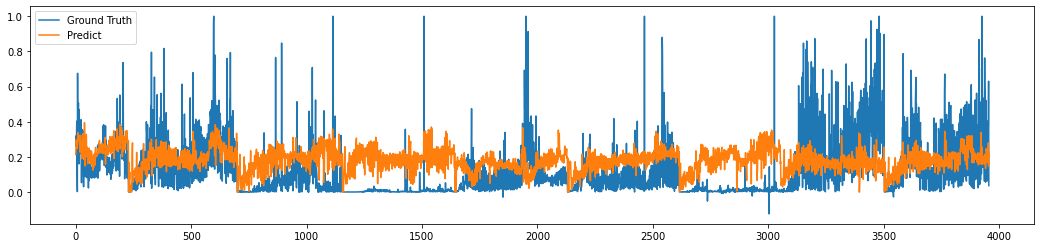

124/124 [==============================] - 0s 2ms/step - loss: 0.3967 - accuracy: 0.0020
Accuracy: 0.20


In [34]:
predict = city_model.predict(Xc_test)
print("Teste Geral")
printSaveGraph(Xc_test,Yc_test,predict, 'cities_all_test',city_model)

Teste  São Paulo


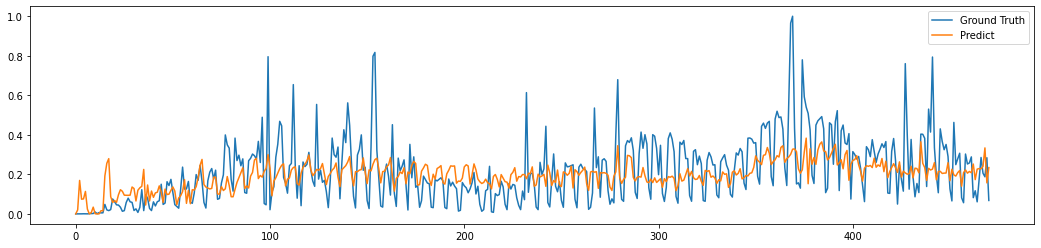

15/15 [==============================] - 1s 2ms/step - loss: 0.5008 - accuracy: 0.0000e+00
Accuracy: 0.00


In [35]:
ctName='São Paulo'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'São Paulo')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_São_Paulo_test',city_model)

Teste  Porto Alegre


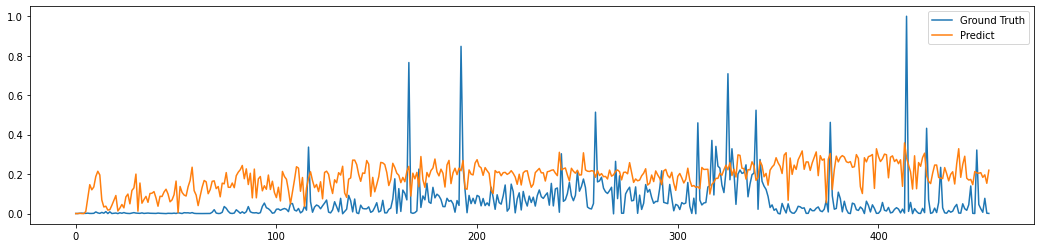

15/15 [==============================] - 0s 3ms/step - loss: 0.2963 - accuracy: 0.0110
Accuracy: 1.10


In [36]:
ctName='Porto Alegre'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])

print("Teste ",'Porto Alegre')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Porto_Alegre_test',city_model)

Teste  Curitiba


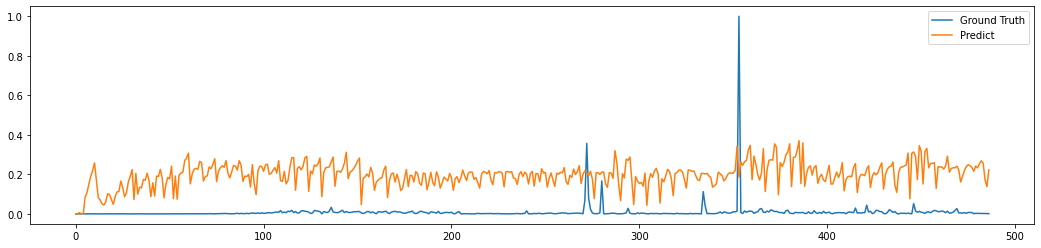

16/16 [==============================] - 0s 3ms/step - loss: 0.2355 - accuracy: 0.0021
Accuracy: 0.21


In [37]:
ctName='Curitiba'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Curitiba')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Curitiba_test',city_model)

Teste  Manaus


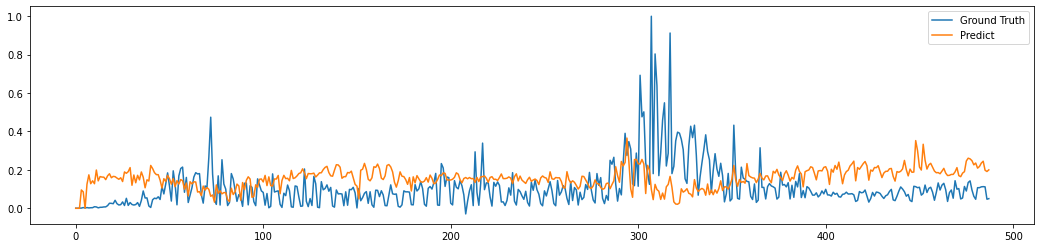

16/16 [==============================] - 0s 2ms/step - loss: 0.3730 - accuracy: 0.0000e+00
Accuracy: 0.00


In [38]:
ctName='Manaus'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Manaus')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Manaus_test',city_model)

Teste  Rio de Janeiro


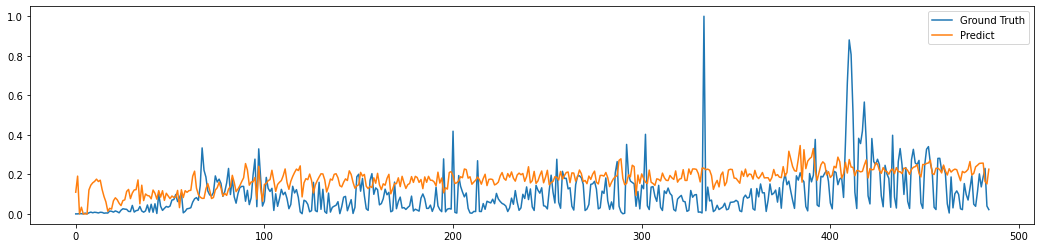

16/16 [==============================] - 0s 3ms/step - loss: 0.3458 - accuracy: 0.0000e+00
Accuracy: 0.00


In [39]:
ctName='Rio de Janeiro'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Rio de Janeiro')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Rio_de_Janeiro_test',city_model)

Teste  Natal


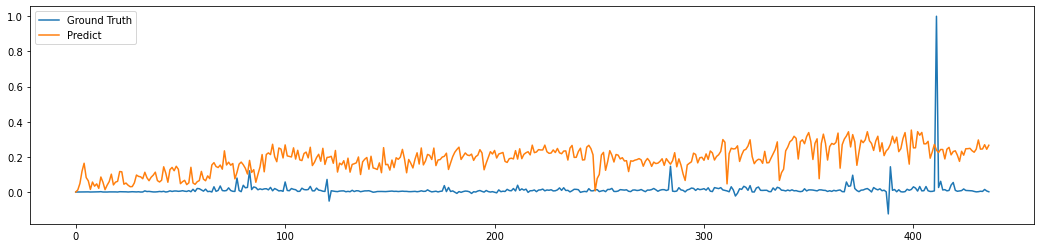

14/14 [==============================] - 0s 5ms/step - loss: 0.2300 - accuracy: 0.0023
Accuracy: 0.23


In [40]:
ctName='Natal'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Natal')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Natal_test',city_model)

Teste  Ribeirão Preto


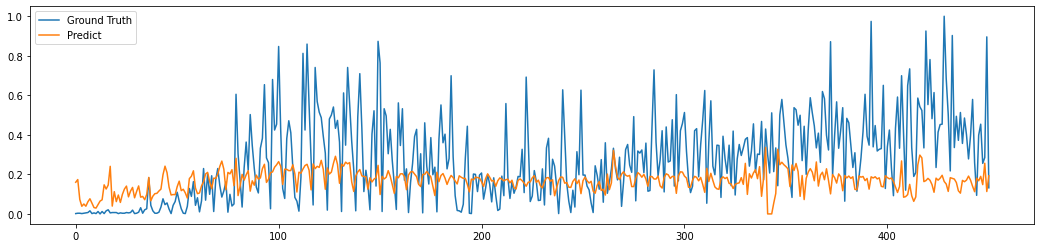

15/15 [==============================] - 0s 2ms/step - loss: 0.6409 - accuracy: 0.0022
Accuracy: 0.22


In [41]:
ctName='Ribeirão Preto'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Ribeirão Preto')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Ribeirão_Preto_test',city_model)

Teste  Campinas


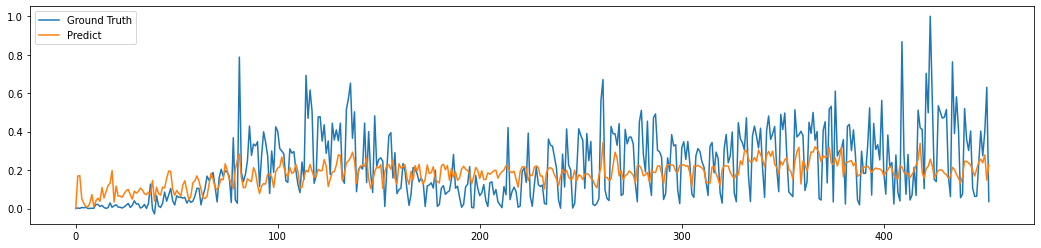

15/15 [==============================] - 0s 2ms/step - loss: 0.4996 - accuracy: 0.0000e+00
Accuracy: 0.00


In [42]:
ctName='Campinas'
Xc_test, Yc_test = getCorrespondentData(mobility_ct_dict[ctName],cases_ct_dict[ctName], 
                                        mob_date_ct_dict[ctName], cases_date_ct_dict[ctName])
print("Teste ",'Campinas')
predict = city_model.predict(Xc_test)
printSaveGraph(Xc_test,Yc_test,predict, 'cities_Campinas_test',city_model)

In [43]:
# import gzip
# import urllib.request
# import io

# # response = urllib.request.urlopen('https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time_changesOnly.csv.gz')
# # compressed_file = io.BytesIO(response.read())

# # print(decompressed_file)



# import requests

# url = 'https://github.com/wcota/covid19br/blob/master/cases-brazil-cities-time_changesOnly.csv.gz'
# filename = url.split("/")[-1]
# with open(filename, "wb") as f:
#     r = requests.get(url)
#     f.write(r.content)
    
# gz_file = open(filename, "r")
# decompressed_file = gzip.GzipFile(fileobj=gz_file)
# print(decompressed_file)
# data = pd.read_csv(decompressed_file)
# print(data)

#### Incluindo dados de vacinação como feature 

In [44]:
def getData():
    cases_df = getAllRegionsCovid(regions_list_BR,regions_abbr_BR)
    mob_df = getAllRegionsGroups(regions_list_BR)
    
    mobility_all = []
    cases_all = []
    mobility_dates = []
    cases_dates = []
    mobility_dict = {}
    cases_dict = {}
    vaccinated_all = []
    for r in regions_list_BR:
        newCases = cases_df[r]['newCases'].values
        newCases_norm = newCases/np.max(newCases)
        vaccinated = cases_df[r]['vaccinated'].values
        scaler = MinMaxScaler(feature_range=(-1,1))        
        mobility_norm = scaler.fit_transform(mob_df[r][categories_google_mobility].values)
        vaccinated_norm = np.nan_to_num(vaccinated)
        vaccinated_norm = vaccinated_norm/np.max(vaccinated_norm)
        covid_dates = cases_df[r]['date'].values
        
        mob_dates = mob_df[r]['date'].values
        mob_dates += np.timedelta64(7,'D') # com offset de 7 dias
        
        mobility_dict[r] = mobility_norm
        cases_dict[r] = newCases_norm
        
        
        for i in range(len(newCases_norm)):
            
            if covid_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
                cases_all.append(newCases_norm[i]) 
                cases_dates.append(covid_dates[i])
                vaccinated_all.append(vaccinated_norm[i])
            
        for i in range(len(mobility_norm)):
            if mob_dates[i] in covid_dates: 
                date_index = np.where(covid_dates == mob_dates[i])
                mob_vac = np.insert(mobility_norm[i],6,vaccinated_norm[date_index])
            else:
                mob_vac = np.insert(mobility_norm[i],6,0)
            if mob_dates[i] >= np.datetime64('2020-06-01T00:00:00.000000000'):
                mobility_all.append(mob_vac)
                mobility_dates.append(mob_dates[i])
        mobility_dict[r] = np.array(mobility_all)
    Y_data = (np.array([cases_all]).T)
    X_data = np.array(mobility_all)        
    return X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict, vaccinated_all


X_data, Y_data, mobility_dates, cases_dates, mobility_dict, cases_dict, vaccinated = getData()

print(X_data.shape)
print(Y_data.shape)

(11286, 7)
(11178, 1)


In [45]:
X_filter, Y_filter = getCorrespondentData(X_data,Y_data, mobility_dates,cases_dates)
print(X_filter.shape)
print(Y_filter.shape)

(11055, 7)
(11055, 1)


In [46]:
X_train = X_filter[:9000]
Y_train = Y_filter[:9000]
X_test = X_filter[9000:]
Y_test = Y_filter[9000:]

In [47]:
model = Sequential()
model.add(Dense(7, input_dim=7, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(14, activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(1, activation='relu'))

In [48]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=700, batch_size=180)

Epoch 1/700
50/50 [==============================] - 3s 2ms/step - loss: 0.8278 - accuracy: 0.0104
Epoch 2/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5858 - accuracy: 0.0110
Epoch 3/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5688 - accuracy: 0.0107
Epoch 4/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5681 - accuracy: 0.0104
Epoch 5/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5580 - accuracy: 0.0091
Epoch 6/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5552 - accuracy: 0.0087
Epoch 7/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5534 - accuracy: 0.0108
Epoch 8/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5530 - accuracy: 0.0105
Epoch 9/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5528 - accuracy: 0.0113
Epoch 10/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5486 - accuracy: 0.0103
Epoch 11/

50/50 [==============================] - 0s 2ms/step - loss: 0.5260 - accuracy: 0.0104
Epoch 84/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5261 - accuracy: 0.0093: 0s - loss: 0.5270 - accuracy: 0.
Epoch 85/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5240 - accuracy: 0.0096
Epoch 86/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5233 - accuracy: 0.0127
Epoch 87/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5224 - accuracy: 0.0098
Epoch 88/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5236 - accuracy: 0.0109
Epoch 89/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5211 - accuracy: 0.0109
Epoch 90/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5227 - accuracy: 0.0097
Epoch 91/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5201 - accuracy: 0.0120
Epoch 92/700
50/50 [==============================] - 0s 3ms/step - loss: 0.523

50/50 [==============================] - 0s 2ms/step - loss: 0.5173 - accuracy: 0.0116
Epoch 164/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5200 - accuracy: 0.0116
Epoch 165/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5172 - accuracy: 0.0112
Epoch 166/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5212 - accuracy: 0.0107
Epoch 167/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5219 - accuracy: 0.0106
Epoch 168/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5207 - accuracy: 0.0103
Epoch 169/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5161 - accuracy: 0.0090
Epoch 170/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5216 - accuracy: 0.0110
Epoch 171/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5165 - accuracy: 0.0109
Epoch 172/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5202 - accuracy: 0.0106
Epoc

50/50 [==============================] - 0s 2ms/step - loss: 0.5222 - accuracy: 0.0102
Epoch 245/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5238 - accuracy: 0.0100
Epoch 246/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5197 - accuracy: 0.0109
Epoch 247/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5183 - accuracy: 0.0104
Epoch 248/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5152 - accuracy: 0.0120
Epoch 249/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5177 - accuracy: 0.0103
Epoch 250/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5194 - accuracy: 0.0113
Epoch 251/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5192 - accuracy: 0.0115
Epoch 252/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5223 - accuracy: 0.0122
Epoch 253/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5196 - accuracy: 0.0108
Epoc

50/50 [==============================] - 0s 2ms/step - loss: 0.5197 - accuracy: 0.0088
Epoch 326/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5168 - accuracy: 0.0103
Epoch 327/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5146 - accuracy: 0.0101
Epoch 328/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5193 - accuracy: 0.0090
Epoch 329/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5207 - accuracy: 0.0111
Epoch 330/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5137 - accuracy: 0.0127
Epoch 331/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5195 - accuracy: 0.0111
Epoch 332/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5176 - accuracy: 0.0095
Epoch 333/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5234 - accuracy: 0.0097
Epoch 334/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5175 - accuracy: 0.0103
Epoc

50/50 [==============================] - 0s 3ms/step - loss: 0.5248 - accuracy: 0.0100
Epoch 406/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5183 - accuracy: 0.0111
Epoch 407/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5190 - accuracy: 0.0106
Epoch 408/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5156 - accuracy: 0.0119
Epoch 409/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5183 - accuracy: 0.0107
Epoch 410/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5181 - accuracy: 0.0099
Epoch 411/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5167 - accuracy: 0.0107
Epoch 412/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5183 - accuracy: 0.0097
Epoch 413/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5192 - accuracy: 0.0085
Epoch 414/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5152 - accuracy: 0.0119
Epoc

50/50 [==============================] - 0s 3ms/step - loss: 0.5293 - accuracy: 0.0109
Epoch 486/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5273 - accuracy: 0.0108
Epoch 487/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5265 - accuracy: 0.0086
Epoch 488/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5266 - accuracy: 0.0107
Epoch 489/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5274 - accuracy: 0.0111
Epoch 490/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5230 - accuracy: 0.0104
Epoch 491/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5228 - accuracy: 0.0109
Epoch 492/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5237 - accuracy: 0.0120
Epoch 493/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5221 - accuracy: 0.0072 ETA: 0s - loss: 0.5208 - accuracy: 0.0044
Epoch 494/700
50/50 [==============================] - 0s 2ms/s

50/50 [==============================] - 0s 2ms/step - loss: 0.5185 - accuracy: 0.0099
Epoch 566/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5189 - accuracy: 0.0101
Epoch 567/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5178 - accuracy: 0.0089
Epoch 568/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5181 - accuracy: 0.0111
Epoch 569/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5189 - accuracy: 0.0104
Epoch 570/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5120 - accuracy: 0.0092
Epoch 571/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5177 - accuracy: 0.0102
Epoch 572/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5185 - accuracy: 0.0110
Epoch 573/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5183 - accuracy: 0.0096
Epoch 574/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5170 - accuracy: 0.0119
Epoc

50/50 [==============================] - 0s 2ms/step - loss: 0.5181 - accuracy: 0.0086
Epoch 646/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5191 - accuracy: 0.0107
Epoch 647/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5105 - accuracy: 0.0109
Epoch 648/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5140 - accuracy: 0.0096
Epoch 649/700
50/50 [==============================] - 0s 3ms/step - loss: 0.5108 - accuracy: 0.0108
Epoch 650/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5124 - accuracy: 0.0101
Epoch 651/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5147 - accuracy: 0.0105
Epoch 652/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5143 - accuracy: 0.0117
Epoch 653/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5137 - accuracy: 0.0109
Epoch 654/700
50/50 [==============================] - 0s 2ms/step - loss: 0.5395 - accuracy: 0.0117
Epoc

In [49]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, Y_train)
print('Accuracy: %.2f' % (accuracy*100))

282/282 [==============================] - 1s 1ms/step - loss: 0.5181 - accuracy: 0.0106
Accuracy: 1.06


In [50]:
print("MobilitY_test Features")
print(X_test[:5])
print("X_test shape: ",X_test.shape)
print("Teste ",regions_list_BR[21])

print("Covid Cases")
print(Y_test[:5])
print("Y_test shape: ",Y_test.shape)

_, accuracY_test = model.evaluate(X_test, Y_test)
print('AccuracY_test: %.2f' % (accuracY_test*100))

MobilitY_test Features
[[ 0.59574468  0.37931034  0.32231405  0.3         0.68085106 -0.36363636
   0.57926416]
 [ 0.68085106  0.44827586  0.33884298  0.4         0.70212766 -0.36363636
   0.59729896]
 [ 0.74468085  0.47586207  0.25619835  0.525       0.78723404 -0.36363636
   0.61457936]
 [ 0.91489362  0.55862069  0.27272727  0.525       0.74468085 -0.45454545
   0.63243079]
 [ 0.46808511  0.43448276  0.30578512  0.275       0.53191489 -0.36363636
   0.64450761]]
X_test shape:  (2055, 7)
Teste  State of Rondônia
Covid Cases
[[0.39927331]
 [0.23455793]
 [0.38837303]
 [0.11182883]
 [0.13726282]]
Y_test shape:  (2055, 1)
65/65 [==============================] - 0s 2ms/step - loss: 0.5079 - accuracy: 0.0097
AccuracY_test: 0.97


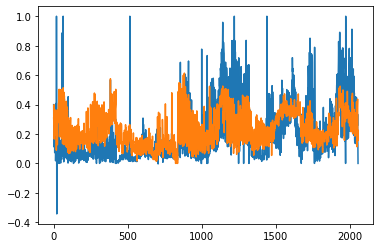

In [51]:
predict = model.predict(X_test)
plt.plot(Y_test)
plt.plot(predict)
plt.show()

Teste  State of Roraima


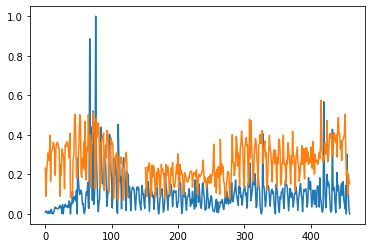

In [52]:
X_test = mobility_dict[regions_list_BR[22]][-460:,:]
Y_test = cases_dict[regions_list_BR[22]][-460:]
Y_test = Y_test.reshape((len(Y_test),1))
print("Teste ",regions_list_BR[22])
predict = model.predict(X_test)
plt.plot(Y_test)
plt.plot(predict)
plt.show()

Teste  State of Santa Catarina


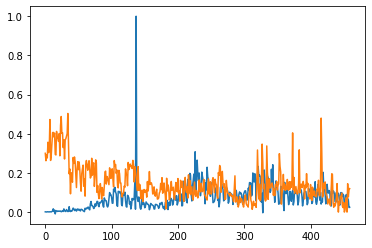

In [53]:
X_test = mobility_dict[regions_list_BR[23]][-460:,:]
Y_test = cases_dict[regions_list_BR[23]][-460:]
Y_test = Y_test.reshape((len(Y_test),1))
print("Teste ",regions_list_BR[23])
predict = model.predict(X_test)
plt.plot(Y_test)
plt.plot(predict)
plt.show()

Teste  State of São Paulo


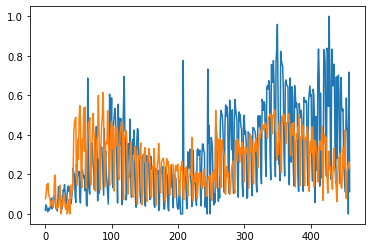

In [57]:
X_test = mobility_dict[regions_list_BR[24]][-460:,:]
Y_test = cases_dict[regions_list_BR[24]][-460:]
Y_test = Y_test.reshape((len(Y_test),1))
#print(X_test)
#print(Y_test[50:55])
print("Teste ",regions_list_BR[24])
predict = model.predict(X_test)
#print(predict[50:55])
plt.plot(Y_test)
plt.plot(predict)
plt.show()

Teste  State of Sergipe


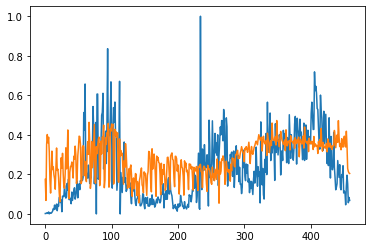

In [55]:
X_test = mobility_dict[regions_list_BR[25]][-460:,:]
Y_test = cases_dict[regions_list_BR[25]][-460:]
Y_test = Y_test.reshape((len(Y_test),1))
print("Teste ",regions_list_BR[25])
predict = model.predict(X_test)
plt.plot(Y_test)
plt.plot(predict)
plt.show()

Teste  State of Tocantins


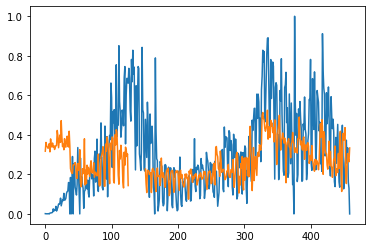

In [56]:
X_test = mobility_dict[regions_list_BR[26]][-460:,:]
Y_test = cases_dict[regions_list_BR[26]][-460:]
Y_test = Y_test.reshape((len(Y_test),1))
print("Teste ",regions_list_BR[26])
predict = model.predict(X_test)
plt.plot(Y_test)
plt.plot(predict)
plt.show()